In [70]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

# matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [71]:
df = pd.read_csv('extracted_features/df_features_cutted_classes_mfcc7_cutted features.csv')
print(df.shape)
df.head()

(3418, 42)


,file_name,zcr_mean,zcr_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_2_mean,spectral_bandwidth_2_std,spectral_bandwidth_3_mean,spectral_bandwidth_3_std,spectral_bandwidth_4_mean,...,mfccs_6_mean,mfccs_7_mean,mfccs_1_std,mfccs_2_std,mfccs_3_std,mfccs_4_std,mfccs_5_std,mfccs_6_std,mfccs_7_std,label
0,22564_Wedding_music.wav,0.070,0.052,1592.894,837.747,2045.648,537.049,2708.924,468.247,2708.924,...,16.339,-3.228,55.087,34.763,21.004,16.305,17.201,11.593,10.033,8
1,2170_Wedding_music.wav,0.063,0.013,1221.528,261.625,1518.883,309.207,2166.347,311.463,2166.347,...,2.701,-20.735,39.937,21.021,10.863,12.045,11.556,9.241,8.503,8
2,12235_Dance_music.wav,0.055,0.039,2488.919,850.331,2774.207,355.493,3285.023,259.509,3285.023,...,22.049,18.266,56.005,30.493,17.400,14.194,10.092,11.339,9.361,7
3,4743_Dance_music.wav,0.128,0.051,2502.569,613.750,2544.902,343.957,3040.350,236.255,3040.350,...,14.688,-0.655,37.888,16.564,15.945,12.229,9.082,9.681,12.593,7
4,17151_Wedding_music.wav,0.083,0.016,1494.651,138.046,1436.222,139.801,1965.976,178.588,1965.976,...,-29.260,-33.993,26.130,10.938,10.662,7.632,7.892,6.731,5.457,8


In [72]:
label_dict = {  #'Background_music':0,
                # 'Theme_music':0,
                'Jingle':0,
                #'Soundtrack_music':1,
                'Lullaby':1,
                'Video_game_music':2,
                'Christmas_music':3,
                'Dance_music':4,
                'Wedding_music':5}
                # 'Birthday_music':9} 

# Normalization of the features
scalar = MinMaxScaler()
df[df.columns[1:]] = scalar.fit_transform(df[df.columns[1:]])
df['label'] = df['file_name'].apply(lambda x: label_dict[x[:-4].split('_', 1)[1]])
df.head()

,file_name,zcr_mean,zcr_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_2_mean,spectral_bandwidth_2_std,spectral_bandwidth_3_mean,spectral_bandwidth_3_std,spectral_bandwidth_4_mean,...,mfccs_6_mean,mfccs_7_mean,mfccs_1_std,mfccs_2_std,mfccs_3_std,mfccs_4_std,mfccs_5_std,mfccs_6_std,mfccs_7_std,label
0,22564_Wedding_music.wav,0.120567,0.197581,0.238077,0.417976,0.507013,0.349799,0.642921,0.274351,0.642921,...,0.776988,0.513756,0.178495,0.321547,0.266931,0.292381,0.381119,0.329608,0.265748,5
1,2170_Wedding_music.wav,0.108156,0.040323,0.171920,0.111855,0.340589,0.187572,0.474838,0.175643,0.474838,...,0.688197,0.322314,0.117106,0.172039,0.100922,0.187201,0.228113,0.236721,0.212764,5
2,12235_Dance_music.wav,0.093972,0.145161,0.397697,0.424662,0.737191,0.220528,0.821389,0.142933,0.821389,...,0.814163,0.748797,0.182215,0.275091,0.207933,0.240260,0.188432,0.319577,0.242477,4
3,4743_Dance_music.wav,0.223404,0.193548,0.400129,0.298956,0.664745,0.212314,0.745593,0.128293,0.745593,...,0.766239,0.541893,0.108803,0.123549,0.184114,0.191744,0.161056,0.254097,0.354400,4
4,17151_Wedding_music.wav,0.143617,0.052419,0.220575,0.046192,0.314473,0.066952,0.412765,0.091987,0.412765,...,0.480114,0.177336,0.061158,0.062340,0.097631,0.078243,0.128801,0.137593,0.107283,5


In [73]:
# Train-test split of files # Same split as used for VGG model, so test file names are imported
with open('pred_probas/vgg_testset_filenames.txt', 'r') as f:
    test_files = f.readlines()

test_files = [t.strip() for t in test_files]

indices = []
for t in test_files:
    indices.append(df[df.file_name==t].index[0])
    
df_test = df.iloc[indices,:]
df.drop(labels=indices, inplace=True)

cl_weight = dict(pd.Series(df['label']).value_counts(normalize=True))

x_train = df[df.columns[1:-1]]
x_test = df_test[df.columns[1:-1]]
y_train = df['label']
y_test = df_test['label']

In [74]:
experiment_path = 'other/'
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig('plots/' + experiment_path + title.replace(" ", "_") +'.png', bbox_inches='tight')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True, cm_title='Confustion matrix'):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(label_dict))
    print('Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        roles = ['Jingle', 'Lullaby', 'Video_game', 'Christmas',
        'Dance', 'Wedding']#, 'Birthday'] # for beatiful plotting
        plot_confusion_matrix(confusion_matrix(y_test[:len(pred)], pred), classes=roles, title=cm_title)

### Logistic Regression
LR is usually done for binary classification tasks. For this multi-class classification task, the LR is implemented as a one-vs-rest method. That is, 7 separate classifiers are trained. During test time, the class with the highest prob. from among the 7 classifiers is the predicted class.

Accuracy =  0.56
F-score =  0.54
ROC AUC = 0.827
Confusion matrix, without normalization
[[ 9  1  5  4  6  2]
 [ 1 21  2  4  0  1]
 [ 1  0 21  0  3  2]
 [ 5  4  3  9  2  7]
 [ 3  1  2  1 23  0]
 [ 1  6  1  5  3 12]]
CPU times: user 510 ms, sys: 244 ms, total: 754 ms
Wall time: 374 ms


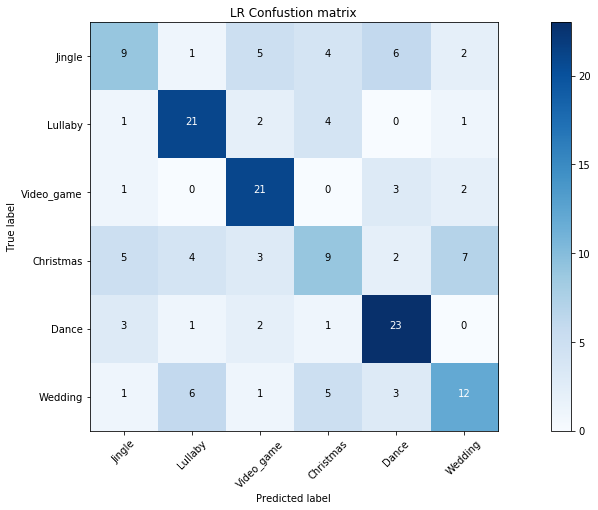

In [75]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, y_train)

# Prediction
pred_probs = lr_classifier.predict_proba(x_test)
display_results(y_test, pred_probs, cm_title='LR Confustion matrix')
# Save
with open('pred_probas/lr_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_LR, f)

### Random Forest

Accuracy =  0.53
F-score =  0.52
ROC AUC = 0.832
Confusion matrix, without normalization
[[10  0  3  3  8  3]
 [ 1 19  1  5  0  3]
 [ 4  0 17  1  1  4]
 [ 3  7  3 10  2  5]
 [ 3  1  1  2 23  0]
 [ 1  6  1  5  3 12]]
CPU times: user 6.2 s, sys: 256 ms, total: 6.45 s
Wall time: 6.06 s


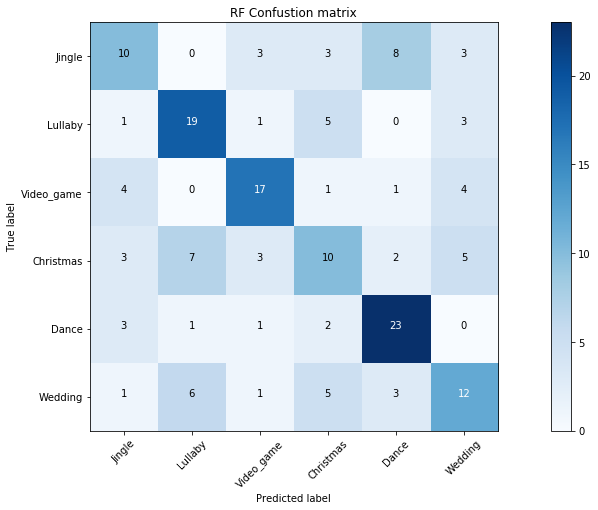

In [76]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)
display_results(y_test, pred_probs, cm_title='RF Confustion matrix')

# Save
with open('pred_probas/rf_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_RF, f)

### Gradient Boosting 

Accuracy =  0.58
F-score =  0.57
ROC AUC = 0.829
Confusion matrix, without normalization
[[12  3  2  2  6  2]
 [ 0 21  1  5  0  2]
 [ 2  0 17  1  2  5]
 [ 5  7  1 12  1  4]
 [ 2  1  0  2 24  1]
 [ 0  6  0  5  4 13]]
CPU times: user 25.6 s, sys: 365 ms, total: 25.9 s
Wall time: 25.6 s


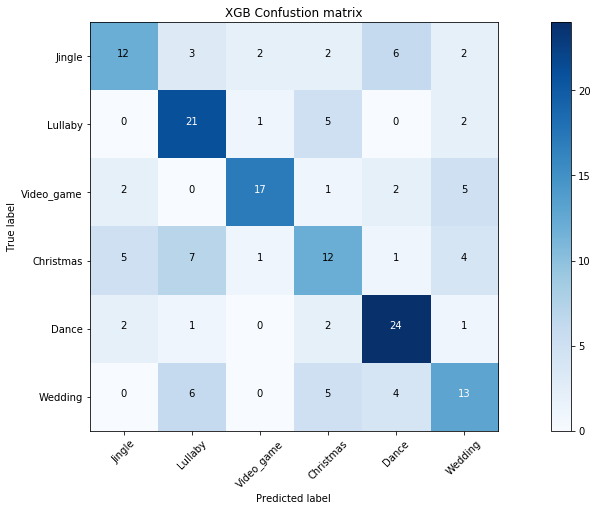

In [77]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train, y_train)

# Prediction and result
pred_probs = xgb_classifier.predict_proba(x_test)
display_results(y_test, pred_probs, cm_title='XGB Confustion matrix')

# Save
with open('pred_probas/xgb_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_XGB, f)

### Support Vector Machines

Accuracy =  0.58
F-score =  0.58
ROC AUC = 0.839
Confusion matrix, without normalization
[[14  1  2  2  5  3]
 [ 2 16  2  6  0  3]
 [ 2  0 22  1  1  1]
 [ 2  3  3 12  3  7]
 [ 5  1  1  1 22  0]
 [ 2  5  0  5  3 13]]
CPU times: user 20.7 s, sys: 384 ms, total: 21.1 s
Wall time: 20.6 s


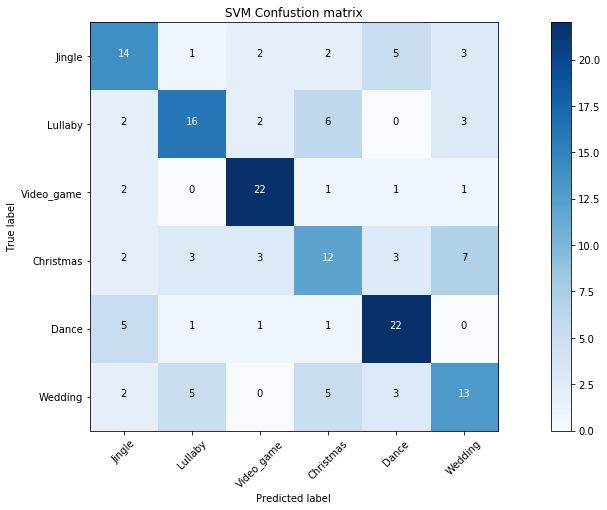

In [79]:
%%time
# Train
svm_classifier = SVC(C=10000.0, probability = True, kernel='rbf') # class_weight=cl_weight,
svm_classifier.fit(x_train, y_train)

# Predict
pred_probs = svm_classifier.predict_proba(x_test)
display_results(y_test, pred_probs, cm_title='SVM Confustion matrix')

# Save
with open('pred_probas/svm_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_SVM, f)

### Most Important Feature
Determine the features that contribute the most towards making the correct classfication

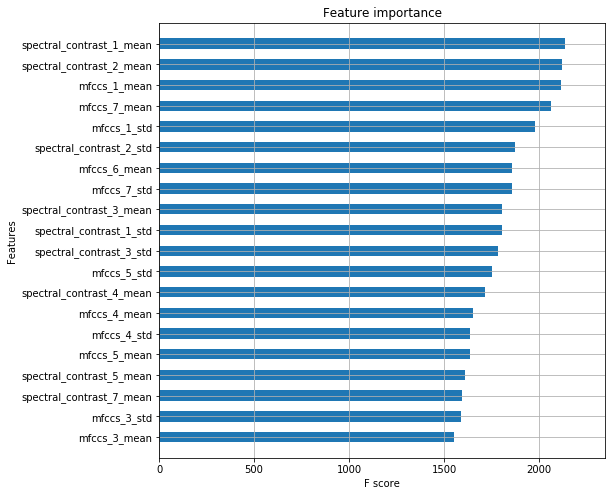

In [80]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=20, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
plt.savefig('plots/other/feature-imp.png', bbox_inches='tight')

The most important features seem to be MFCCs and spectral contrast (mean and std dev in different frequency bins). Use the top N features, build the model and look at the metrics

In [52]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.02024879, 0.02423981, 0.01715619, 0.02097443, 0.01449551,
       0.01617139, 0.01439185, 0.02002419, 0.        , 0.        ,
       0.03690394, 0.03661023, 0.03121977, 0.02964755, 0.02778162,
       0.02581202, 0.02757429, 0.03118521, 0.0323255 , 0.03083967,
       0.02470629, 0.02346234, 0.02427436, 0.02316863, 0.01511748,
       0.01853836, 0.03657568, 0.02102626, 0.02684865, 0.02855909,
       0.02828265, 0.03211818, 0.03562543, 0.03417415, 0.02684865,
       0.02745335, 0.02829993, 0.0302868 , 0.02496545, 0.03206635],
      dtype=float32)

In [81]:
top_n = [10, 20, 30]
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_val = selection.transform(x_val)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                       n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_val)

    # Results
    display_results(y_val, pred_probs, cm = False)     
    print()

Stats for top 10 features:
Accuracy =  0.46
F-score =  0.46
ROC AUC = 0.783
()
Stats for top 20 features:
Accuracy =  0.53
F-score =  0.52
ROC AUC = 0.816
()
Stats for top 30 features:
Accuracy =  0.52
F-score =  0.51
ROC AUC = 0.824
()
